## Character Recognition - CROHME 2023 dataset

Notebook to convert handwritten math equations in an image as latex code

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

import os
import cv2
from transformers import TFViTModel

2024-12-17 20:40:10.421362: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-17 20:40:10.538067: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-17 20:40:10.674680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-17 20:40:10.796704: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-17 20:40:10.824732: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 20:40:10.969456: I tensorflow/core/platform/cpu_feature_gu

In [2]:
# hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 32
LEARNING_RATE = 0.001
MAX_SEQ_LEN = 50
AMOUNT_CHANNELS = 3

### Load data

In [3]:
import xml.etree.ElementTree as ET
missing_attrib_counter = 0
def parse_inkml(inkml_path):
    """
    Parse an .inkml file to extract the corresponding LaTeX label and image name.
    """
    global missing_attrib_counter
    tree = ET.parse(inkml_path)
    root = tree.getroot()

    image_name = None
    latex_code = None
    
    try:
        image_name = os.path.splitext(os.path.basename(inkml_path))[0]
        latex_code = root.find(".//{http://www.w3.org/2003/InkML}annotation[@type='truth']").text
    except AttributeError:
        missing_attrib_counter += 1
        print(missing_attrib_counter)

    return image_name, latex_code

    
def extract_labels_from_inkml(inkml_dir):
    """
    Extract labels for all .inkml files in a directory.
    """
    latex_label_map = {}
    for file in os.listdir(inkml_dir):
        if file.endswith(".inkml"):
            inkml_path = os.path.join(inkml_dir, file)
            image_name, latex_code = parse_inkml(inkml_path)
            if image_name is None or latex_code is None:
                continue
            
            latex_label_map[image_name] = latex_code
            
    return latex_label_map

In [4]:
def match_images_with_labels(img_dir, latex_label_map):
    """
    Match .png images in img_dir with their LaTeX labels using the UI key.
    """
    matched_data = []
    for img_file in os.listdir(img_dir):
        if img_file.endswith(".png"):
            image_name = os.path.splitext(img_file)[0]  # Strip .png extension
            if image_name in latex_label_map:
                matched_data.append((os.path.join(img_dir, img_file), latex_label_map[image_name]))

    return matched_data

In [5]:
def preprocess_image(image_path: str, target_size: int=IMG_SIZE) -> np.ndarray:
    """
    Preprocesses an image by cropping the content area, padding it to make it square, 
    and resizing it to a specified target size.

    Args:
        image_path (str): Path to the input image.
        target_size (int): Target size for resizing the image. Defaults to IMG_SIZE.

    Returns:
        numpy.ndarray: Preprocessed image resized to (target_size, target_size).
    """
    
    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    
    # Detect the bounding box of the content
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    coords = cv2.findNonZero(255 - gray_img)  # Invert the image to find non-white areas
    x, y, w, h = cv2.boundingRect(coords)  # Get bounding box

    # Crop to only keep the content area
    cropped_img = img[y:y+h, x:x+w]

    # Pad to make it square (to keep aspect ratio of handwriting the same)
    height, width, _ = cropped_img.shape
    max_dim = max(height, width)
    pad_top = (max_dim - height) // 2
    pad_bottom = max_dim - height - pad_top
    pad_left = (max_dim - width) // 2
    pad_right = max_dim - width - pad_left

    padded_img = cv2.copyMakeBorder(
        cropped_img,
        pad_top, pad_bottom, pad_left, pad_right,
        cv2.BORDER_CONSTANT,
        value=[255, 255, 255]  # White padding
    )

    # Resize to the target size
    resized_img = cv2.resize(padded_img, (target_size, target_size), interpolation=cv2.INTER_AREA)

    return resized_img

In [6]:
def load_image(img_path: str) -> tf.Tensor:
    """
    Loads and preprocesses an image, then normalizes its pixel values.

    Args:
        img_path (str): Path to the input image.

    Returns:
        tf.Tensor: A tensor representation of the normalized image with pixel values in [0, 1].
    """
    img_arr = preprocess_image(img_path)
    img_ds = tf.convert_to_tensor(img_arr, dtype=tf.float32)
    img_ds /= 255.0
    return img_ds

# Function to tokenize and pad labels
def preprocess_label(label: str, tokenizer: 'Tokenizer', max_len: int) -> np.ndarray:
    """
    Tokenizes and pads a text label to a specified maximum length.

    Args:
        label (str): The input text label.
        tokenizer (Tokenizer): A tokenizer object to encode the label.
        max_len (int): Maximum length for the padded sequence.

    Returns:
        numpy.ndarray: A tokenized and padded representation of the label.
    """
    # Tokenize the label
    tokens = tokenizer.encode(label)

    # Pad the label
    padded_tokens = tf.keras.preprocessing.sequence.pad_sequences(
        [tokens], padding='post', maxlen=max_len
    )
    return padded_tokens[0]  # Return the first (and only) batch

# Convert your data into a TensorFlow dataset
def create_tf_dataset(
    matched_data: list[tuple[str, str]],
    tokenizer: 'Tokenizer',
    batch_size: int=BATCH_SIZE,
    max_len: int=MAX_SEQ_LEN,
    img_size: int=224
) -> tf.data.Dataset:
    """
    Creates a TensorFlow dataset from matched image paths and text labels.

    Args:
        matched_data (list of tuples): A list of (image_path, label) pairs.
        tokenizer (Tokenizer): A tokenizer to process the text labels.
        batch_size (int): Batch size for the dataset.
        max_len (int): Maximum sequence length for tokenized labels.
        img_size (int): Target size for image resizing.

    Returns:
        tf.data.Dataset: A batched, shuffled, and prefetched dataset.
    """
    
    image_paths, labels = zip(*matched_data)

    images = [load_image(image_path) for image_path in image_paths]
    tokenized_labels = [preprocess_label(label, tokenizer, max_len) for label in labels]
    
    # Create the TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((images, tokenized_labels))

    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.shuffle(buffer_size=100000)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)  # Prefetch for better performance

    return dataset

In [7]:
inkml_train_dir = "CROHME23/TC11_CROHME23/INKML/train/CROHME2023_train"
train_labels = extract_labels_from_inkml(inkml_train_dir)

img_train_dir = "CROHME23/TC11_CROHME23/IMG/train/CROHME2013_train" # typo in dir name: is 2023 data as well
matched_train_data = match_images_with_labels(img_train_dir, train_labels)


inkml_val_dir = "CROHME23/TC11_CROHME23/INKML/val/CROHME2023_val"
val_labels = extract_labels_from_inkml(inkml_val_dir)

img_val_dir = "CROHME23/TC11_CROHME23/IMG/val/CROHME2023_val"
matched_val_data = match_images_with_labels(img_val_dir, val_labels)


inkml_test_dir = "CROHME23/TC11_CROHME23/INKML/test/CROHME2023_test"
test_labels = extract_labels_from_inkml(inkml_test_dir)

img_test_dir = "CROHME23/TC11_CROHME23/IMG/test/CROHME2023_test"
matched_test_data = match_images_with_labels(img_test_dir, test_labels)

### Load custom Latex Tokenizer

To convert latex code into seperate tokens that can be used by neural networks. So the latex code is encoded into different tokens, and each token corresponds to a different function or operation (also see the example below).

In [8]:
import json
import re

class LatexTokenizer:
    def __init__(self, vocab_path: str):
        # Load vocabulary from JSON file
        with open(vocab_path, 'r') as f:
            vocab = json.load(f)
        
        # Create token-to-ID and ID-to-token mappings
        self.special_tokens = vocab["special_tokens"]
        self.commands = vocab["commands"]
        self.symbols = vocab["symbols"]
        self.digits = vocab["digits"]
        self.letters = vocab["letters"]
        self.environments = vocab["environments"]
        self.functions = vocab["functions"]
        self.operators = vocab["operators"]
        
        self.tokens = (
            self.special_tokens + self.commands + self.symbols +
            self.digits + self.letters +
            self.environments + self.functions +
            self.operators
        )
        
        self.token_to_id = {token: idx for idx, token in enumerate(self.tokens)}
        self.id_to_token = {idx: token for token, idx in self.token_to_id.items()}


        self.pad_token, self.start_token, self.end_token, self.unknown_token = self.special_tokens

    def _tokenize_latex(self, text: str) -> list[str]:
        """
        Tokenizes the LaTeX input text by matching tokens in the vocabulary.
        """
        tokens = []
        i = 0
        while i < len(text):
            matched = False
            # Try to find the longest match in the vocabulary
            for token in sorted(self.tokens, key=len, reverse=True):  # Sort by length for longest match first
                if text[i:i+len(token)] == token:
                    tokens.append(token)
                    i += len(token)  # Move past the matched token
                    matched = True
                    break  # Once a match is found, move on to the next part of the text
            if not matched:
                # If no match, treat as unknown token or skip
                tokens.append(self.unknown_token)
                i += 1  # Move past the unmatched character
        return tokens
        
    def text_to_ids(self, text: str) -> list[int]:
        """
        Tokenizes a LaTeX string into a sequence of IDs.
        """
        text = re.sub("\s*", "", text)
        tokens = self._tokenize_latex(text)
        ids = [self.token_to_id.get(token, self.token_to_id[self.unknown_token]) for token in tokens]
        return [self.token_to_id[self.start_token]] + ids + [self.token_to_id[self.end_token]]
    
    def ids_to_text(self, ids: list[int]) -> str:
        """
        Converts a sequence of IDs back into a LaTeX string.
        """
        tokens = [self.id_to_token.get(i, self.unknown_token) for i in ids]
        return " ".join(tokens).replace(self.start_token, "").replace(self.end_token, "").strip()

    # aliases
    def encode(self, text: str) -> list[int]:
        return self.text_to_ids(text)

    def decode(self, ids: list[int]) -> list[str]:
        return self.ids_to_text(ids)

    @property
    def vocab_size(self) -> int:
        """
        Returns the size of the vocabulary.
        """
        return len(self.tokens)

In [9]:
path_to_latex_vocab = "latex_vocab.json"
tokenizer = LatexTokenizer(path_to_latex_vocab)

START_TOKEN = tokenizer.start_token
END_TOKEN = tokenizer.end_token


train_dataset = create_tf_dataset(matched_train_data, tokenizer, batch_size=BATCH_SIZE, max_len=MAX_SEQ_LEN)
val_dataset = create_tf_dataset(matched_val_data, tokenizer, batch_size=BATCH_SIZE, max_len=MAX_SEQ_LEN)
test_dataset = create_tf_dataset(matched_test_data, tokenizer, batch_size=BATCH_SIZE, max_len=MAX_SEQ_LEN)

I0000 00:00:1734464419.313602   92753 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-17 20:40:19.314350: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-12-17 20:41:41.780304: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1384857600 exceeds 10% of free system memory.


#### Latex tokenizer example

In [10]:
# Example LaTeX string
latex_input = "\\frac{x}{y} + \\sin\\left(\\theta\\right)"

# Tokenize and detokenize
token_ids = tokenizer.text_to_ids(latex_input)
print("Token IDs:", token_ids)

decoded_latex = tokenizer.ids_to_text(token_ids)
print("Decoded LaTeX:", decoded_latex)

# Vocabulary size
print("Vocabulary Size:", tokenizer.vocab_size)

Token IDs: [1, 4, 151, 285, 152, 151, 286, 152, 142, 9, 30, 147, 191, 31, 148, 2]
Decoded LaTeX: \frac { x } { y } + \sin \left ( \theta \right )
Vocabulary Size: 366


### Load pretrained Vision Transformer (ViT)

In [11]:
# load pretrained Vision Transformer
vit = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
patch_size = 16
seq_len = (IMG_SIZE // patch_size)**2 + 1
hidden_size = 768
output_shape_model = (seq_len, hidden_size)

def preprocess(inputs: tf.Tensor) -> tf.Tensor:
    """
    Preprocesses input images for the Vision Transformer model by scaling pixel values 
    to [0, 1] and normalizing them in "torch" mode.

    Args:
        inputs (tf.Tensor): Input images as tensors.

    Returns:
        tf.Tensor: Preprocessed tensor images ready for the Vision Transformer.
    """
    # Scale pixel values to the range [0, 1] and normalize using "torch" mode
    inputs = tf.keras.applications.imagenet_utils.preprocess_input(inputs, mode="torch")
    # Convert KerasTensor to TensorFlow Tensor explicitly
    inputs = tf.convert_to_tensor(inputs)
    return inputs

def get_vit_encoder() -> tf.keras.Model:
    """
    Builds a Vision Transformer (ViT) encoder model using pre-trained weights.

    Returns:
        tf.keras.Model: A ViT encoder model with input shape (IMG_SIZE, IMG_SIZE, AMOUNT_CHANNELS).
    """
    input_layer = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, AMOUNT_CHANNELS), name="image_input")

    # Preprocess inputs using the updated function
    # transpose because for some reason model flips the order, so tranposing here to compensate
    processed_inputs = tf.keras.layers.Lambda(lambda x: tf.transpose(x, perm=[0, 3, 1, 2]))(input_layer)
    
    # Ensure inputs are compatible with TFViTModel
    outputs = tf.keras.layers.Lambda(lambda x: vit(x).last_hidden_state, output_shape=output_shape_model)(processed_inputs)

    return tf.keras.Model(inputs=input_layer, outputs=outputs, name="vit_encoder")

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


### Load decoder

Two types of decoders. The first decoder outputs a sequence of tokens, while the second type outputs a sequence of probabilities of tokens. These are also called "soft tokens".

The second decoder is made to be differentiable. 

In [12]:
def get_decoder(vocab_size: int, hidden_size: int) -> tf.keras.Model:
    """
    Creates a GRU-based decoder for sequence generation.

    Args:
        vocab_size (int): Vocabulary size for the output sequences.
        hidden_size (int): Hidden size for the GRU and embedding layers.

    Returns:
        tf.keras.Model: A decoder model for generating sequences.
    """
    decoder_inputs = layers.Input(shape=(None,))
    encoder_outputs = layers.Input(shape=(None, hidden_size))  # ViT feature size

    embedding = layers.Embedding(input_dim=vocab_size, output_dim=hidden_size)(decoder_inputs)
    gru_output = layers.GRU(hidden_size, return_sequences=True)(embedding, initial_state=None)
    outputs = layers.Dense(vocab_size, activation="softmax")(gru_output)

    return tf.keras.Model(inputs=[decoder_inputs, encoder_outputs], outputs=outputs, name="decoder")

def get_decoder_with_soft_tokens(vocab_size: int, hidden_size: int) -> tf.keras.Model:
    """
    Creates a GRU-based decoder that accepts soft token inputs (probability distributions).

    Args:
        vocab_size (int): Vocabulary size for the output sequences.
        hidden_size (int): Hidden size for the GRU and embedding layers.

    Returns:
        tf.keras.Model: A decoder model for generating sequences from soft tokens.
    """
    decoder_inputs = layers.Input(shape=(None, vocab_size))  # Soft tokens as input (probabilities)
    encoder_outputs = layers.Input(shape=(None, hidden_size))  # ViT feature size

    # Create the embedding layer
    embedding_matrix = layers.Embedding(input_dim=vocab_size, output_dim=hidden_size)

    # Use a Lambda layer for the weighted sum calculation
    def weighted_sum(inputs):
        # `inputs` contains the soft tokens (decoder_inputs) and the embedding weights
        soft_tokens, embeddings = inputs
        return tf.matmul(soft_tokens, embeddings)

    # Pass the embedding weights dynamically to the Lambda layer
    embedded_inputs = layers.Lambda(weighted_sum, output_shape=(None, hidden_size))(
        [decoder_inputs, embedding_matrix(tf.range(vocab_size))]
    )

    # GRU and Dense layers
    gru_output = layers.GRU(hidden_size, return_sequences=True)(embedded_inputs, initial_state=None)
    outputs = layers.Dense(vocab_size, activation="softmax")(gru_output)

    return tf.keras.Model(inputs=[decoder_inputs, encoder_outputs], outputs=outputs, name="decoder")

### Custom Layers

Scheduled Sampling layer makes sure that at a portion of the training is done with predictions from the model itself, as opposed to the ground-truth (i.e. the correct latex tokens used as input for teacher forcing).

Scheduled sampling layer now uses a gumbel_softmax to determine the predicted tokens as opposed to the non-differentiable argmax. This is so that backpropagation can work properly and all gradients can be calculated correctly (at least that's how it should be).

In [13]:
from tensorflow.keras.layers import Layer

class ScheduledSamplingLayer(layers.Layer):
    def __init__(self, temperature=1.0, **kwargs):
        """
        Scheduled sampling layer that blends ground truth tokens and predicted tokens for training.
        Args:
            temperature: Initial temperature for Gumbel-Softmax.
        """
        super(ScheduledSamplingLayer, self).__init__(**kwargs)
        self.temperature = temperature

    def gumbel_softmax(self, logits):
        """
        Perform Gumbel-Softmax sampling.
        Args:
            logits: Tensor of shape (batch_size, vocab_size), un-normalized logits.

        Returns:
            Tensor of shape (batch_size, vocab_size), softmax probabilities with Gumbel noise.
        """
        uniform_noise = tf.random.uniform(tf.shape(logits), minval=1e-6, maxval=1.0)
        gumbel_noise = -tf.math.log(-tf.math.log(uniform_noise))
        noisy_logits = logits + gumbel_noise
        return tf.nn.softmax(noisy_logits / self.temperature)

        
    def call(self, inputs):
        """
        Scheduled sampling during training.
        Args:
            inputs: A dictionary containing:
                - "token_inputs": Ground truth token sequence, shape (batch_size, sequence_length).
                - "decoder_output_logits": Decoder's predicted logits, shape (batch_size, vocab_size).
                - "time_step": Current time step as a scalar.
                - "teacher_forcing_prob": Probability of using teacher forcing.

        Returns:
            Tensor of shape (batch_size, vocab_size), logits or probabilities for the next step.
        """
        token_inputs = inputs["token_inputs"]
        decoder_output = inputs["decoder_output"]
        time_step = inputs["time_step"]
        teacher_forcing_prob = inputs["teacher_forcing_prob"]
        
        teacher_forcing_prob_scalar = tf.reduce_mean(teacher_forcing_prob)

        # Extract the ground truth token for the current time step
        token_input_t = tf.cast(tf.gather(token_inputs, time_step, axis=1), dtype=tf.int32)

        # One-hot encode the ground truth token for blending
        token_input_t_one_hot = tf.one_hot(token_input_t, depth=tf.shape(decoder_output)[-1])
        token_input_t_one_hot = tf.expand_dims(token_input_t_one_hot, axis=1)

        # Blend ground truth and predicted probabilities
        blended_logits = teacher_forcing_prob_scalar * tf.math.log(token_input_t_one_hot + 1e-8) + \
                         (1.0 - teacher_forcing_prob_scalar) * decoder_output

        # Apply Gumbel-Softmax for differentiable sampling
        sampled_probabilities = self.gumbel_softmax(blended_logits)

        # Return probabilities for training, tokens for inference
        next_token_probability = sampled_probabilities[:, time_step, :]
        next_token_probability = tf.expand_dims(next_token_probability, axis=1)
        
        return next_token_probability

class ConcatenateLayer(layers.Layer):
    """
    Custom Keras layer to concatenate decoder inputs with the next time step input.
    """
    def call(self, inputs: tuple[tf.Tensor, tf.Tensor]) -> tf.Tensor:
        """
        Concatenates the two input tensors along axis 1.
        """
        decoder_inputs, next_input_t = inputs
        return tf.concat([decoder_inputs, next_input_t], axis=1)

class ConcatenateLayerSingle(layers.Layer):
    """
    Custom Keras layer to concatenate a list of tensors along a specified axis.
    """
    def call(self, input_list: list[tf.Tensor], axis: int=1) -> tf.Tensor:
        """
        Concatenates a list of input tensors along the specified axis.
        """
        return tf.concat(input_list, axis=1)
        

### Build Model

Build the model with the scheduled sampling layer. It generates a sequence of latex tokens sequentially. 

In [14]:
def build_model(vocab_size: int) -> tf.keras.Model:
    """
    Builds a model consisting of a Vision Transformer (ViT) encoder, a GRU-based decoder, 
    and scheduled sampling for sequence generation.

    Args:
        vocab_size (int): The size of the output vocabulary.

    Returns:
        tf.keras.Model: A compiled Keras model.
    """
    encoder = get_vit_encoder()
    decoder = get_decoder_with_soft_tokens(vocab_size, hidden_size=512)

    image_inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, AMOUNT_CHANNELS), name="image_inputs")
    token_inputs = layers.Input(shape=(None,), name="token_inputs")  # Teacher forcing tokens
    teacher_forcing_prob = layers.Input(shape=(), name="teacher_forcing_prob", dtype=tf.float32)  # Teacher forcing probability
    
    encoder_outputs = encoder(image_inputs)
    encoder_outputs = layers.Dense(512)(encoder_outputs)
    
    start_token_id = tokenizer.token_to_id[START_TOKEN]
    decoder_inputs_prob_distrib = tf.one_hot(tf.fill([BATCH_SIZE, 1], start_token_id), vocab_size)

    scheduled_sampling = ScheduledSamplingLayer()
    concatenate_layer = ConcatenateLayer()
    concatenate_layer_single = ConcatenateLayerSingle()

    accumulated_tokens = decoder_inputs_prob_distrib

    for t in range(MAX_SEQ_LEN - 1):
        t_tensor = tf.convert_to_tensor(t, dtype=tf.int32)  # Ensure `t` is a tensor
        
        # Pass inputs to the decoder
        decoder_output_t = decoder([accumulated_tokens, encoder_outputs])
        
        # Apply scheduled sampling
        next_token_prob_distrib = scheduled_sampling({
            "token_inputs": token_inputs, 
            "decoder_output": decoder_output_t, 
            "time_step": t_tensor,  # Pass as a tensor
            "teacher_forcing_prob": teacher_forcing_prob
        })

        # accumulate all previous tokens
        accumulated_tokens = concatenate_layer([accumulated_tokens, next_token_prob_distrib])

    decoder_output_t = decoder([accumulated_tokens, encoder_outputs])
    return tf.keras.Model(
        inputs=[image_inputs, token_inputs, teacher_forcing_prob],
        outputs=accumulated_tokens
    )

In [15]:
model = build_model(vocab_size=tokenizer.vocab_size)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)

#### Check if gradients exist

In [ ]:
# Mock inputs
hidden_layer = 512
vocab_size = tokenizer.vocab_size

decoder_inputs_mock = tf.random.uniform([BATCH_SIZE, MAX_SEQ_LEN, vocab_size], dtype=tf.float32)
encoder_outputs_mock = tf.random.uniform([BATCH_SIZE, MAX_SEQ_LEN, hidden_layer], dtype=tf.float32)

# Run the model on mock inputs
with tf.GradientTape() as tape:
    decoder = get_decoder_with_soft_tokens(vocab_size, hidden_layer)
    tape.watch(decoder_inputs_mock)  # Ensure gradients are being tracked
    tape.watch(encoder_outputs_mock)
    decoder_output_mock = decoder([decoder_inputs_mock, encoder_outputs_mock])

# Check if gradients exist for Dense layer kernel and bias
grads = tape.gradient(decoder_output_mock, decoder.trainable_variables)
for grad, var in zip(grads, decoder.trainable_variables):
    if grad is None:
        print(f"WARNING: No gradient for variable {var.name}")
    else:
        print(f"Gradient exists for variable {var.name}, shape: {grad.shape}")

#### Add ground-truth and the probability to use teacher forcing to the dataset inputs 

In [17]:
# Modify dataset to return both inputs as required by model
def modify_dataset_for_model(dataset, teacher_forcing_prob):
    return dataset.map(lambda img, label: ((tf.cast(img, dtype=tf.float32), tf.cast(label, dtype=tf.int32), tf.cast(tf.fill(tf.shape(label)[:1], teacher_forcing_prob), dtype=tf.float32)), tf.cast(label, dtype=tf.int32)))

# the fraction of tokens that are trained on is ground truth,
# other part is predicted tokens with the model
teacher_forcing_prob = 0.5

train_dataset_model = modify_dataset_for_model(train_dataset, teacher_forcing_prob)
val_dataset_model = modify_dataset_for_model(val_dataset, teacher_forcing_prob)
test_dataset_model = modify_dataset_for_model(test_dataset, teacher_forcing_prob)

### Train/Load Model

For some reason, even after making the layers differentiable, the gradients for Kernel and Bias could not properly be calculated. Maybe the layers disconnect somewhere or a layer is still non-differentiable. Either way, this is probably the main issue with the model.

In [18]:
train_model = False
models_path = "../models/CROHME"

if train_model:
    del test_dataset
    del test_dataset_model
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=20,
        restore_best_weights=True
    )
    
    history = model.fit(
        train_dataset_model,
        validation_data=val_dataset_model,
        epochs=250,
        callbacks=[early_stopping]
    )

else:
    history = None
    latest_version_num = 6
    latest_version = [file_name for file_name in sorted(os.listdir(models_path), reverse=True) if f"00{latest_version_num}" in file_name][0]
    latest_version_path = os.path.join(models_path, latest_version)
    print(latest_version_path)
    model.load_weights(latest_version_path)

../models/CROHME/char-recog-model_crohme_006.weights.h5


/home/marcsa/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Save Model

In [19]:
counter = 1

def is_existing_file(path, counter):
    return os.path.isfile(os.path.join(path, f"char-recog-model_crohme_{counter:03d}.weights.h5"))

while is_existing_file(models_path, counter):
    counter += 1

if train_model:
    model.save_weights(os.path.join(models_path, f"char-recog-model_crohme_{counter:03d}.weights.h5"))

### Evaluate Model

In [20]:
import pandas as pd
!pip install matplotlib
import matplotlib.pyplot as plt
if history is not None:
    history_frame = pd.DataFrame(history.history)
    history_frame.loc[:, ['loss', 'val_loss']].plot()
    history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

Defaulting to user installation because normal site-packages is not writeable


In [21]:
# if history is not None:
loss, accuracy = model.evaluate(test_dataset_model)
print(loss, accuracy)
print(test_dataset_model)

2024-12-17 20:41:48.463255: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1384857600 exceeds 10% of free system memory.
/home/marcsa/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['image_inputs', 'token_inputs', 'teacher_forcing_prob']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


71/71 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.6579 - loss: 3.2076
3.2119898796081543 0.6572975516319275
<_MapDataset element_spec=((TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 50), dtype=tf.int32, name=None), TensorSpec(shape=(32,), dtype=tf.float32, name=None)), TensorSpec(shape=(32, 50), dtype=tf.int32, name=None))>


In [22]:
def plot_n_images(X, y=None, n=10, row_spacing=0.5):
    plt.figure(figsize=(10, 5))
    # Show the first n images if available, otherwise show all images
    for i in range(min(n, X.shape[0])):  
        plt.subplot(n // 5 + 1, 5, i+1)
        plt.imshow(X[i], cmap='gray')  # Assuming 28x28 images
        if y is not None:
            plt.title(label_map[y[i]])
        plt.axis('off')

    plt.subplots_adjust(hspace=row_spacing)
    plt.show()

#### Predictions with test data (including ground-truth as input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
(32, 50, 366)
5 6 ( 1 9 8 6 ) 1 3 1 9  \Biggr
f ^ { a b c } c ^ { b } c ^ { c }  \max
( k - 1 ) ( n + D ) + e  =
x - y = 1  \end{align} \Pr \rangle
\prime v ( x ) ^ 2 = 1 - y ^ 2  <UNK>
h _ N = \tan ( \pi / p )
X ^ { 1 1 } + X ^ { 1 2 } + X ^ { 2 1 } = C  \text
\alpha = - 1 + \frac { 1 } { n }  \text
\mu 1 0 - 3 0 \cos \theta  \Omega Y \delta h \setminus
2 \log { 2 }  \cdots \biggr \overset
e x t  \wedge
\sqrt { 2 } C _ f = C _ a  \underbrace
( 3 x - 1 )  <UNK>
r \rightarrow \sqrt \right r }  \frac \pm
s _ { b - s _ { a b } + s _ { a b } s _ { b } = 0  1
( 0 + 1 ) + ( 0 + \cdot )
\frac { 1 } { 2 } \sum _ a [ ( p ^ a ) ^ 2 + ( q _ a ) ^ 2 ] = 1
B = \sec { x ^ 2 } { n ^ 2 } f \left ( \frac { k x } { n } , \frac { l x } { n } \right ) I _ n ( x )
\frac { 1 } { c }
6 u ( x - y )  \pm
\frac { \overleftrightarrow r } { 2 } \sqrt { f }  \hookrightarrow
\sum _ i r _ i + \sum _ i s _ i
\frac { 1 } { x ^ 2 \nvDash  <UNK> <UNK>
r = | x | = \sqrt { x _ 1 ^ 2 +

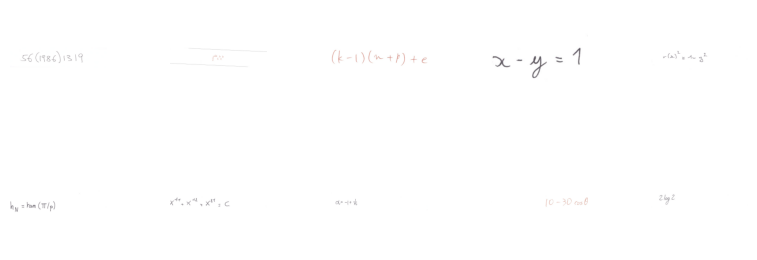

In [23]:
for image_label_tuple, label in test_dataset_model:
    predictions = model.predict(image_label_tuple)
    print(predictions.shape)
    predicted_tokens = np.argmax(predictions, axis=-1)
    for token_seq in predicted_tokens:
        print(tokenizer.decode([token for token in token_seq if token != 0]))

    plot_n_images(image_label_tuple[0].numpy().astype(np.float32))
    break

The predictions here seem pretty decent, often only adding addition latex at the end that is unnecessary. However, we'll see that this not the model actually predicting this based on the images, but it copying the ground-truth that was given as input. 

### Validation on Custom images

In [28]:
def evaluate_autoregressive(
    model: tf.keras.Model, 
    dataset: tf.data.Dataset, 
    start_token: str, 
    end_token: str, 
    max_length: int = MAX_SEQ_LEN
) -> float:
    """
    Evaluates the model using an autoregressive decoding strategy.
    (generating a token based on all previous tokens)

    Args:
        model (tf.keras.Model): The trained sequence generation model.
        dataset (tf.data.Dataset): A dataset of image inputs and true tokens.
        start_token (str): The start token for decoding.
        end_token (str): The end token for decoding.
        max_length (int): The maximum sequence length to decode. Defaults to MAX_SEQ_LEN.

    Returns:
        float: The accuracy of the model on the dataset.
    """
    correct = 0
    total = 0

    # Encode the start and end tokens
    start_token_encoded = tokenizer.encode(start_token)[0]
    end_token_encoded = tokenizer.encode(end_token)[0]
    
    for (image_inputs, true_tokens) in dataset:
        batch_size = image_inputs.shape[0]
        
        # Initialize generated tokens as integers
        generated_tokens = tf.fill((batch_size, 1), start_token_encoded)  # Start token as an ID

        # Pass image inputs through the encoder
        encoder_outputs = model.get_layer("vit_encoder")(image_inputs)
        
        # Apply the extra Dense layer to match the decoder input shape
        encoder_outputs = model.get_layer("dense_1")(encoder_outputs)  # Apply Dense layer
        
        # Autoregressive decoding loop
        for _ in range(max_length):
            generated_tokens_OH = tf.one_hot(generated_tokens, depth=tokenizer.vocab_size)
            
            # Predict the next token
            decoder_outputs_prob_distrib = model.get_layer("decoder")([generated_tokens_OH, encoder_outputs])
            # decoder_outputs = tf.argmax(decoder_outputs_prob_distrib, axis=-1)
            
            next_tokens = tf.argmax(decoder_outputs_prob_distrib[:, -1, :], axis=-1, output_type=tf.int32)
            # print(next_tokens)
            
            generated_tokens = tf.concat([generated_tokens, tf.expand_dims(next_tokens, axis=-1)], axis=-1)

            # Stop if all sequences have reached the end token
            if tf.reduce_all(next_tokens == end_token_encoded):
                break

        # Compare generated tokens with true tokens (excluding padding and special tokens)
        for gen, true in zip(generated_tokens.numpy(), true_tokens.numpy()):
            # Strip padding and end tokens for comparison
            gen = gen[:np.where(gen == end_token_encoded)[0][0]] if end_token_encoded in gen else gen
            true = true[:np.where(true == end_token_encoded)[0][0]] if end_token_encoded in true else true
            if np.array_equal(gen, true):
                correct += 1
            total += 1

    accuracy = correct / total
    print(f"Autoregressive accuracy: {accuracy * 100:.2f}%")
    return accuracy

In [ ]:
# Evaluate
# evaluate_autoregressive(model, test_dataset, START_TOKEN, END_TOKEN)

In [25]:
def predict_tokens(
    model: tf.keras.Model, 
    image_input: tf.Tensor, 
    start_token: str, 
    end_token: str, 
    max_length: int = MAX_SEQ_LEN
) -> float:
    """
    Evaluates the model using an autoregressive decoding strategy.
    (generating a token based on all previous tokens)

    Args:
        model (tf.keras.Model): The trained sequence generation model.
        dataset (tf.data.Dataset): A dataset of image inputs and true tokens.
        start_token (str): The start token for decoding.
        end_token (str): The end token for decoding.
        max_length (int): The maximum sequence length to decode. Defaults to MAX_SEQ_LEN.

    Returns:
        float: The accuracy of the model on the dataset.
    """
    correct = 0
    total = 0

    # Encode the start and end tokens
    start_token_encoded = tokenizer.encode(start_token)[0]
    end_token_encoded = tokenizer.encode(end_token)[0]
    
    # Initialize generated tokens as integers
    generated_tokens = tf.fill((1, 1), start_token_encoded)  # Start token as an ID

    # Pass image inputs through the encoder
    encoder_outputs = model.get_layer("vit_encoder")(image_input)
    
    # Apply the extra Dense layer to match the decoder input shape
    encoder_outputs = model.get_layer("dense_1")(encoder_outputs)  # Apply Dense layer
    
    # Autoregressive decoding loop
    for _ in range(max_length):
        generated_tokens_OH = tf.one_hot(generated_tokens, depth=tokenizer.vocab_size)
        
        # Predict the next token
        decoder_outputs_prob_distrib = model.get_layer("decoder")([generated_tokens_OH, encoder_outputs])
        
        next_tokens = tf.argmax(decoder_outputs_prob_distrib[:, -1, :], axis=-1, output_type=tf.int32)
        generated_tokens = tf.concat([generated_tokens, tf.expand_dims(next_tokens, axis=-1)], axis=-1)

        # Stop if all sequences have reached the end token
        if tf.reduce_all(next_tokens == end_token_encoded):
            break

    return generated_tokens

When loading our own custom images, we can see that it doesn't actually predict a proper sequence of latex. It just get's stuck on the } character and keeps repeating it. This leads me to believe that the model bases its predictions on the ground-truth that was given as input, not on the actual image. This is quite a common issue with models that use teacher forcing, and is called *exposure bias*.

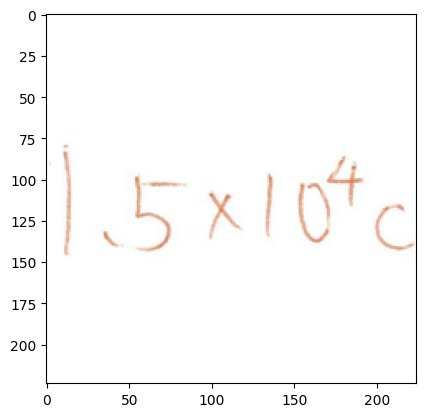

} } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } }


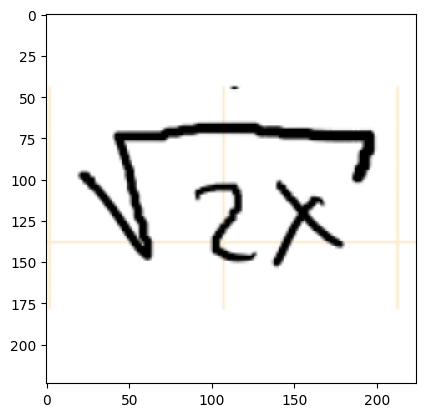

} } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } }


In [26]:
import matplotlib.pyplot as plt

image_test = load_image("CROHME23/TC11_CROHME23/IMG/test/CROHME2023_test/form_5_175_E874.png")
plt.imshow(image_test, cmap='gray')
plt.show()

image_test = tf.expand_dims(image_test, axis=0)
prediction_token_ids = tf.squeeze(predict_tokens(model, image_test, START_TOKEN, END_TOKEN), axis=0).numpy()
print(tokenizer.decode(prediction_token_ids))

# print(os.path.isfile("../Images characters/Handwritten/Math - Complex/eq_008.png"))
image_test = load_image("../Images characters/Handwritten/Math - Complex/eq_008.png")
plt.imshow(image_test, cmap='gray')
plt.show()

image_test = tf.expand_dims(image_test, axis=0)
prediction_token_ids = tf.squeeze(predict_tokens(model, image_test, START_TOKEN, END_TOKEN), axis=0).numpy()
print(tokenizer.decode(prediction_token_ids))